# Indiana Pines

1. Import dependencies

In [1]:
import random
import torch
import numpy as np

import torch.utils.data as data

from torch import nn
from torch.optim.lr_scheduler import StepLR

from src.util.hsi import (
    extract_patches,
    DimReductionType,
    PreProcessType,
    preprocess_hsi,
    train_test_band_patch_split,
    reduce_hsi_dim,
    read_fixed_labels_mask,
    train_test_split_by_mask,
)
from src.model.lenet import FullyConvolutionalLeNet
from src.util.torch import resolve_torch_device
from src.data.indian_pines import load_indian_pines
from src.visualization.plot import (
    plot_segmentation_comparison,
    plot_epoch_generic,
    plot_masked_segmentation_comparison,
)
from src.data.dataset_decorator import UnlabeledDatasetDecorator, BinaryDatasetDecorator
from src.model.lenet import PuLeNet
from src.trainer.multiview_trainer import MultiViewTrainer
from src.model.ensemble import MultiViewEnsemble
from src.trainer.base_trainer import AdamOptimizedModule
from src.trainer.classification_trainer import ClassificationTrainer
from src.util.reporting import (
    classification_trainer,
    create_model_name,
    report_run,
    read_report_to_show,
)
from src.trainer.co_learning import DemocraticCoLearningTrainer
from src.model.dbda import DBDA
from src.model.facto_former import FactoFormer
from src.model.fdssc import FDSSC_f
from src.model.gscvit import GSCViT
from src.model.ssrn import SSRN
from src.util.scheduler import CosineLRSchedulerWrapper
from src.util.dict_ext import arrange_and_repeat

2. Prepare env

In [2]:
y = torch.rand(16, 64)
coef, idx = torch.max(y, dim=0)


In [3]:
batch_size = 32
patch_size = 9
target_dim = 75

pre_process_type = PreProcessType.STANDARTIZATION
dim_reduction_type = DimReductionType.PCA

In [4]:
random_seed = 42

random.seed(random_seed)
torch.manual_seed(random_seed)
np.random.seed(random_seed)

device = resolve_torch_device()

generator = torch.Generator()
generator.manual_seed(random_seed)

In [5]:
f"Device is {device}"

'Device is cuda'

3. Load dataset

In [6]:
image, labels = load_indian_pines()

image_h, image_w, image_c = image.shape

In [7]:
_, image = preprocess_hsi(image, pre_process_type)

In [8]:
num_classes = len(np.unique(labels))

f"Number of classes {num_classes}"

'Number of classes 17'

In [9]:
examples_per_class = arrange_and_repeat(num_classes, 20)

4. Reduce dimensions

In [10]:
_, target_dim, image = reduce_hsi_dim(
    image, target_dim, dim_reduction_type, device, random_seed
)

5. Prepare dataset

In [11]:
x, y = extract_patches(image, labels, patch_size=patch_size)

In [12]:
mask = read_fixed_labels_mask("indian-pines-v1.npy")

x_train, y_train, x_test, y_test = train_test_split_by_mask(x, y, mask)

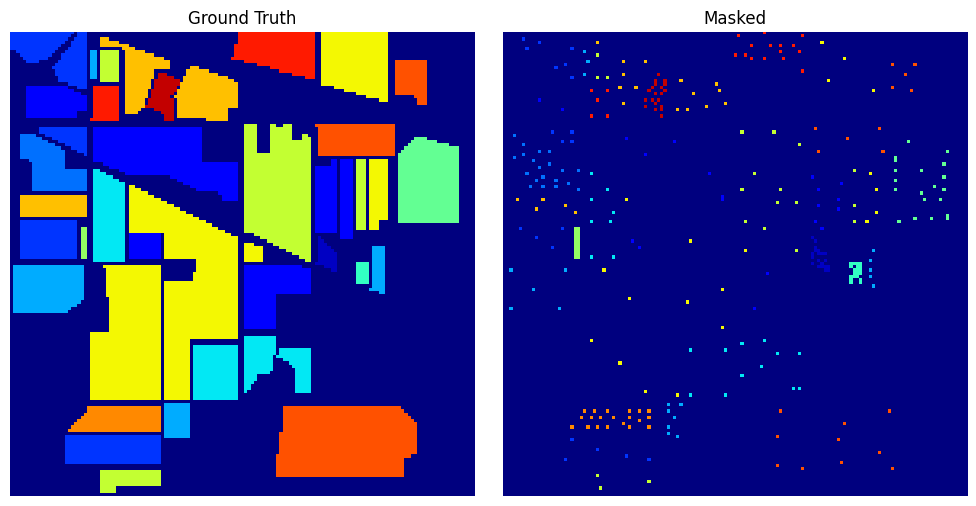

In [13]:
_ = plot_masked_segmentation_comparison(y.reshape(image_h, image_w), mask)

In [14]:
x_all = torch.tensor(x, dtype=torch.float32).permute(0, 3, 1, 2)
y_all = torch.tensor(y, dtype=torch.long)
x_train = torch.tensor(x_train, dtype=torch.float32).permute(0, 3, 1, 2)
y_train = torch.tensor(y_train, dtype=torch.long)
x_test = torch.tensor(x_test, dtype=torch.float32).permute(0, 3, 1, 2)
y_test = torch.tensor(y_test, dtype=torch.long)

In [15]:
train_dataset = data.TensorDataset(x_train, y_train)
test_dataset = data.TensorDataset(x_test, y_test)
full_dataset = data.TensorDataset(x_all, y_all)

In [16]:
train_loader = data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    generator=generator,
)
test_loader = data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    generator=generator,
)
unlabeled_loader = data.DataLoader(
    UnlabeledDatasetDecorator(test_dataset),
    batch_size=batch_size,
    shuffle=False,
    generator=generator,
)
full_loader = data.DataLoader(
    full_dataset,
    batch_size=batch_size,
    shuffle=False,
    generator=generator,
)
predict_loader = data.DataLoader(
    UnlabeledDatasetDecorator(full_dataset),
    batch_size=batch_size,
    shuffle=False,
    generator=generator,
)

6. Train semi-supervised model

In [17]:
num_epochs = 300

lenet = AdamOptimizedModule(
    FullyConvolutionalLeNet(target_dim, num_classes),
    lr=1e-3,
    scheduler=lambda opt: StepLR(
        opt, step_size=num_epochs // 10, gamma=0.9
    ),
)

lenet_trainer = ClassificationTrainer(
    num_epochs=num_epochs,
    num_classes=num_classes,
    criterion=nn.CrossEntropyLoss(),
    device=device,
    dl_accumulation_steps=2,
)

facto_former = AdamOptimizedModule(
    FactoFormer(
        img_size=[target_dim, patch_size, patch_size],
        spatial_patch=[target_dim, 1, 1],
        spectral_patch=[1, patch_size, patch_size],
        spatial_embed_dim=64,
        spectral_embed_dim=32,
        bands=target_dim,
        n_classes=num_classes,
        depth=5,
        n_heads=4,
        qkv_bias=True,
        attn_p=0.3,
        proj_p=0.3,
    ),
    lr=1e-4,
)

facto_former_trainer = ClassificationTrainer(
    num_epochs=num_epochs,
    num_classes=num_classes,
    criterion=nn.CrossEntropyLoss(),
    device=device,
    dl_accumulation_steps=2,
)

gsvit = AdamOptimizedModule(
    GSCViT(
        num_classes=num_classes,
        channels=target_dim,
        heads=(16, 16, 16),
        depth=(1, 1, 1),
        group_spatial_size=[3, 3, 3],
        dropout=0.3,
        padding=[1, 1, 1],
        dims=(256, 128, 64),
        num_groups=[8, 8, 8],
    ),
    lr=1e-4,
)

gsvit_trainer = ClassificationTrainer(
    num_epochs=num_epochs,
    num_classes=num_classes,
    criterion=nn.CrossEntropyLoss(),
    device=device,
    dl_accumulation_steps=2,
)

dbda_lr = 1e-3
dbda = AdamOptimizedModule(
    DBDA(
        band=target_dim,
        classes=num_classes,
    ),
    lr=dbda_lr,
    scheduler=lambda optimizer: CosineLRSchedulerWrapper(
        optimizer,
        t_initial=num_epochs,
        lr_min=dbda_lr * 0.01,
        warmup_t=int(np.ceil(0.1 * num_epochs)),
        warmup_lr_init=dbda_lr * 0.01,
    ),
)

dbda_trainer = ClassificationTrainer(
    num_epochs=num_epochs,
    num_classes=num_classes,
    criterion=nn.CrossEntropyLoss(),
    device=device,
    dl_accumulation_steps=2,
)

fdscc = AdamOptimizedModule(
    FDSSC_f(
        band=target_dim,
        classes=num_classes,
    ),
    lr=1e-4,
)

fdscc_trainer = ClassificationTrainer(
    num_epochs=num_epochs,
    num_classes=num_classes,
    criterion=nn.CrossEntropyLoss(),
    device=device,
    dl_accumulation_steps=2,
)

ssrn = AdamOptimizedModule(
    SSRN(
        band=target_dim,
        classes=num_classes,
    ),
    lr=1e-3,
)

ssrn_trainer = ClassificationTrainer(
    num_epochs=num_epochs,
    num_classes=num_classes,
    criterion=nn.CrossEntropyLoss(),
    device=device,
    dl_accumulation_steps=2,
)

models = [
    lenet,
    facto_former,
    gsvit,
    dbda,
    fdscc,
    ssrn,
]
trainers = [
    lenet_trainer,
    facto_former_trainer,
    gsvit_trainer,
    dbda_trainer,
    fdscc_trainer,
    ssrn_trainer,
]

co_learning = DemocraticCoLearningTrainer(num_classes, device, max_epochs=10)

FDSSC_f


In [18]:
# from torch import Tensor


# def choose_new_labels_candidates(
#     majority_vote: Tensor, predictions: list[Tensor], weights: list[float]
# ) -> list[Tensor]:
#     predictions_tensor = torch.stack(predictions)
#     agreement_mask = predictions_tensor == majority_vote
#     print(agreement_mask)
#     disagreement_mask = ~agreement_mask
#     weights_tensor = torch.tensor(weights, device=agreement_mask.device).unsqueeze(1)

#     agrees = agreement_mask.float() * weights_tensor
#     disagrees = disagreement_mask.float() * weights_tensor

#     print(agrees)
#     print(disagrees)

#     agrees_weight = torch.sum(agrees, dim=0)

#     print(agrees_weight)

#     disagrees_weight = torch.sum(disagrees, dim=0)

#     print(disagrees_weight)

#     candidates = agrees_weight > disagrees_weight

#     print(candidates)

#     disagreeing_candidates = disagreement_mask & candidates

#     print(disagreeing_candidates)

#     return [torch.nonzero(row, as_tuple=True)[0] for row in disagreeing_candidates]


# majority_vote = torch.tensor([1, 2, 3, 4, 4])
# predictions = [
#     torch.tensor([1, 2, 3, 4, 5]),
#     torch.tensor([3, 1, 2, 5, 4]),
#     torch.tensor([1, 2, 3, 4, 4]),
# ]
# weights = [1, 1, 1]

# choose_new_labels_candidates(majority_vote, predictions, weights)

In [19]:
history, co_learned = co_learning.fit(
    models=models,
    trainers=trainers,
    labeled=train_loader,
    unlabeled=unlabeled_loader,
    eval_dataloader=test_loader,
)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

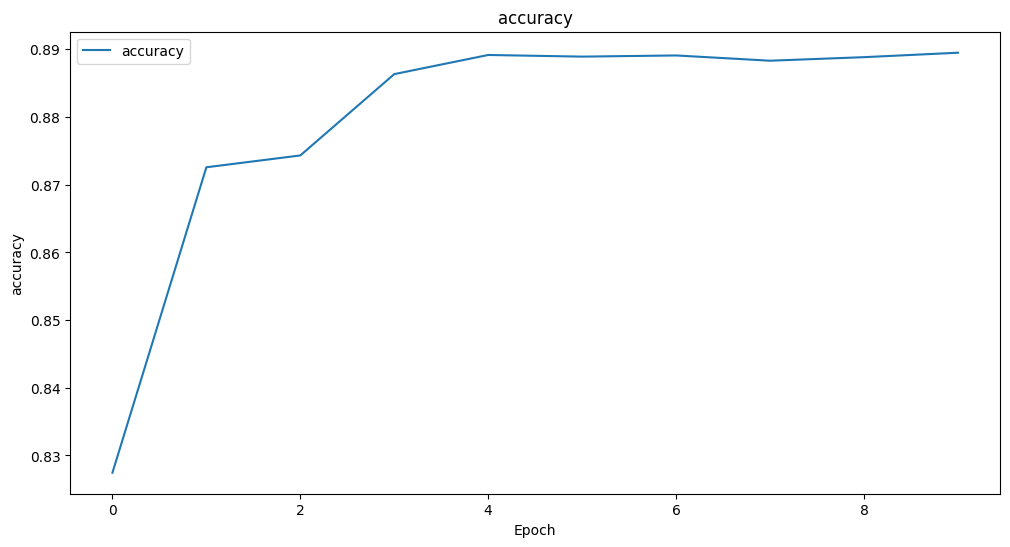

In [20]:
plot_epoch_generic([it["eval_accuracy_overall"] for it in history], desc="accuracy")

In [21]:
validation_result = co_learning.validate(co_learned, full_loader)

validation_result

{'eval_f1': 0.6390492916107178,
 'eval_accuracy_overall': 0.948737382888794,
 'eval_accuracy_avg': 0.6589773893356323,
 'eval_kappa': 0.6045124530792236}

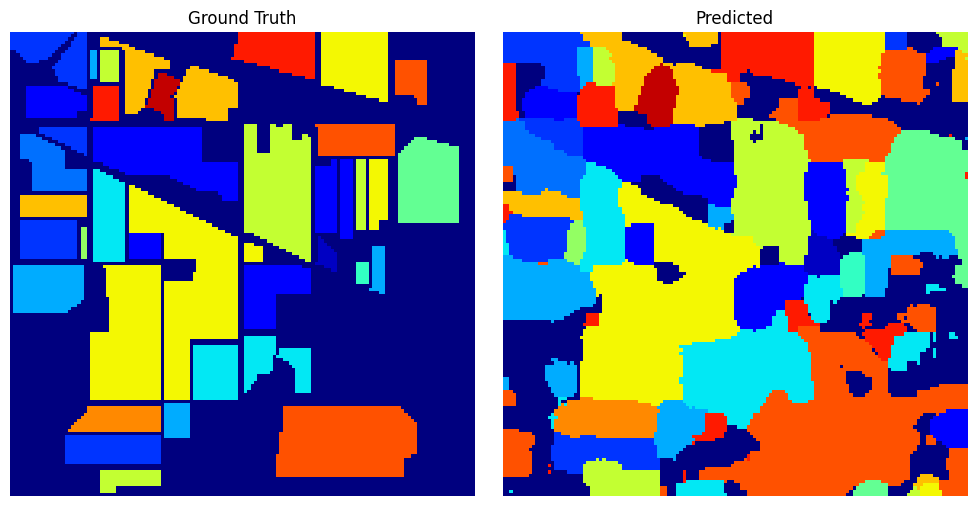

In [22]:
_, y_pred = co_learning.predict(co_learned, predict_loader)
y_pred = torch.cat(y_pred, dim=0)
y_pred = y_pred.reshape(image_h, image_w)

plot_segmentation_comparison(labels, y_pred.cpu().numpy())

6. Write report

In [23]:
model_name = create_model_name("indian_pines_", examples_per_class)
model_category = "democratic_co_learning"

run_params = {
    "num_epochs": num_epochs,
    "batch_size": batch_size,
    "patch_size": patch_size,
    "target_dim": target_dim,
    "pre_process_type": str(pre_process_type),
    "dim_reduction_type": str(dim_reduction_type),
}

report_run(
    model_name=model_name,
    model_category=model_category,
    run_desc="Max 10 epochs",
    run_params=[run_params | it.get_params() for it in models],
    run_metrics=classification_trainer(validation_result),
)

PosixPath('/home/melal/Workspace/spatial-regulated-self-training/reports/runs/indian_pines__0-20_1-20_2-20_3-20_4-20_5-20_6-20_7-20_8-20_9-20_10-20_11-20_12-20_13-20_14-20_15-20_16-20.csv')

In [24]:
read_report_to_show(model_name, sort_by_metric="OA")

,timestamp,model_category,run_desc,params,loss,f1,OA,AA,kappa
6,2025-05-24T23:39:51.672671+00:00,lenet,"More epochs, PCA and scheduler","{""learning_rate"": 0.001, ""num_epochs"": 300, ""b...",2.497706,0.462771,2.424388e+33,0.457883,NaN
71,2025-06-01T07:26:50.004429+00:00,democratic_co_learning,Max 10 epochs,"[{""num_epochs"": 300, ""batch_size"": 32, ""patch_...",NaN,0.639049,9.487374e-01,0.658977,0.604512
68,2025-05-31T20:11:38.302896+00:00,lenet_multiview,"Self learning, 8 epochs, new unlabled shrinking","{""num_epochs"": 15, ""batch_size"": 32, ""patch_si...",NaN,0.364953,9.110223e-01,0.474530,0.441202
53,2025-05-28T15:49:18.248456+00:00,democratic_co_learning,Max 10 epochs,"[{""num_epochs"": 300, ""batch_size"": 32, ""patch_...",NaN,0.623983,9.092148e-01,0.631819,0.567875
64,2025-05-31T12:52:12.314211+00:00,lenet_multiview,"New fixed mask, 2 epochs, new unlabled shrinking","{""num_epochs"": 15, ""batch_size"": 32, ""patch_si...",NaN,0.790402,8.780323e-01,0.787206,0.703928
...,...,...,...,...,...,...,...,...,...
13,2025-05-25T11:05:35.126823+00:00,vit,Add weight decay and smaller lr,"{""hidden_dim"": 64, ""num_layers"": 5, ""num_heads...",2.611931,0.251206,5.845405e-02,0.188966,0.081323
14,2025-05-25T11:26:53.611845+00:00,vit,"Add weight decay, increase dropout and smaller lr","{""hidden_dim"": 64, ""num_layers"": 5, ""num_heads...",2.557661,0.207239,5.841505e-02,0.163187,0.074733
11,2025-05-25T10:20:38.669253+00:00,vit,Add weight decay and smaller lr,"{""hidden_dim"": 64, ""num_layers"": 5, ""num_heads...",3.053134,0.260749,5.337951e-02,0.192771,0.081146
10,2025-05-25T09:30:05.188620+00:00,vit,Add weight decay,"{""hidden_dim"": 64, ""num_layers"": 5, ""num_heads...",5.515652,0.177391,5.255213e-02,0.143306,0.060421


In [25]:
read_report_to_show(model_name, sort_by_metric="OA", model_category=model_category)

,timestamp,run_desc,params,loss,f1,OA,AA,kappa
71,2025-06-01T07:26:50.004429+00:00,Max 10 epochs,"[{""num_epochs"": 300, ""batch_size"": 32, ""patch_...",NaN,0.639049,0.948737,0.658977,0.604512
53,2025-05-28T15:49:18.248456+00:00,Max 10 epochs,"[{""num_epochs"": 300, ""batch_size"": 32, ""patch_...",NaN,0.623983,0.909215,0.631819,0.567875
52,2025-05-28T09:20:45.680745+00:00,Default run,"[{""num_epochs"": 300, ""batch_size"": 32, ""patch_...",NaN,0.291210,0.082646,0.209750,0.108568
